## Bike Rental Usage Prediction - Regression Problem


<table>
  <tr><td>
    <img src="https://upload.wikimedia.org/wikipedia/commons/6/60/Nice_Ride_Bike_Kiosk.jpg"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1. Bike Rental Predictions
  </td></tr>
</table>

---

#### Data Fields Explanation

- Data Reference: 
    - This Hadi Fanaee-T
    - Laboratory of Artificial Intelligence and Decision Support (LIAAD), University of Porto INESC Porto, Campus da FEUP Rua Dr. Roberto Frias, 378 4200 - 465 Porto, Portugal

- Data Description: 
    - instant: record index
    - dteday : date
    - season : season (1:springer, 2:summer, 3:fall, 4:winter)
    - yr : year (0: 2011, 1:2012)
    - mnth : month ( 1 to 12)
    - hr : hour (0 to 23)
    - holiday : wether day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
    - weekday : day of the week
    - workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
    + weathersit : 
        - 1: Clear, Few clouds, Partly cloudy
        - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
        - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    - temp : Normalized temperature in Celsius. The values are divided to 41 (max)
    - hum: Normalized humidity. The values are divided to 100 (max)
    - windspeed: Normalized wind speed. The values are divided to 67 (max)
    - casual: count of casual users
    - registered: count of registered users
    - cnt: count of total rental bikes including both casual and registered
---

In [1]:
# Library imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
# Note this code is only valid if GPU is being used for training

# Before we run the parameter tuning, we will work with little gpu memory allocation
# we will only use that much of memory of gpu as it is needed - allow the growth of gpu memory as it is needed

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


### Load the dataset

In [4]:
# load the data and check few rows

bike = pd.read_csv("resources\\bike-sharing-daily.csv")
bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.805833,0.160446,331,654,985
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.696087,0.248539,131,670,801
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.437273,0.248309,120,1229,1349
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.590435,0.160296,108,1454,1562
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.436957,0.186900,82,1518,1600


In [5]:
# Check the data structure
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  hum         731 non-null    float64
 11  windspeed   731 non-null    float64
 12  casual      731 non-null    int64  
 13  registered  731 non-null    int64  
 14  cnt         731 non-null    int64  
dtypes: float64(3), int64(11), object(1)
memory usage: 85.8+ KB


In [6]:
# Check for missing values

bike.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [7]:
# Check for summary statistics

bike.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.972500,0.507463,3410.000000,6946.000000,8714.000000


### Data Preparation

In [8]:
# we will drop few columns which are not needed

# Drop column instant
bike = bike.drop(labels=['instant', 'casual', 'registered'], axis=1)
bike.head()     

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1/1/2011,1,0,1,0,6,0,2,0.344167,0.805833,0.160446,985
1,1/2/2011,1,0,1,0,0,0,2,0.363478,0.696087,0.248539,801
2,1/3/2011,1,0,1,0,1,1,1,0.196364,0.437273,0.248309,1349
3,1/4/2011,1,0,1,0,2,1,1,0.200000,0.590435,0.160296,1562
4,1/5/2011,1,0,1,0,3,1,1,0.226957,0.436957,0.186900,1600


In [9]:
# We will format the dteday column to appropriate datetime format
bike['dteday'] = pd.to_datetime(bike['dteday'], format='%m/%d/%Y')

# Let us make this column as the index
bike.index = pd.DatetimeIndex(bike['dteday'])

# Now let us drop the original dteday column, as that has been made the index now
bike = bike.drop(labels=['dteday'], axis=1)

# Check the final dataset
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
dteday,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.805833,0.160446,985
2011-01-02,1,0,1,0,0,0,2,0.363478,0.696087,0.248539,801
2011-01-03,1,0,1,0,1,1,1,0.196364,0.437273,0.248309,1349
2011-01-04,1,0,1,0,2,1,1,0.200000,0.590435,0.160296,1562
2011-01-05,1,0,1,0,3,1,1,0.226957,0.436957,0.186900,1600


### Data Visualization

Text(0, 0.5, 'Bike Rental')

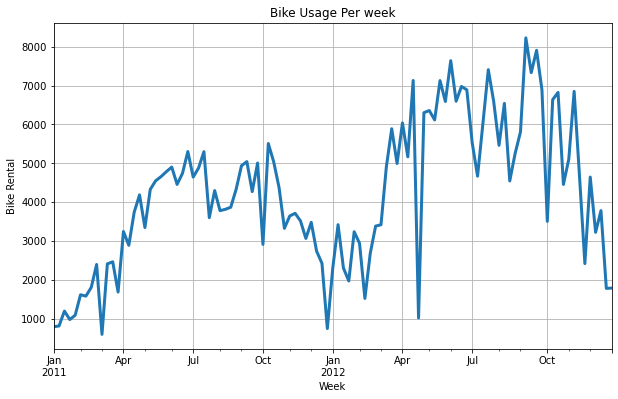

In [11]:
# Lets visualise the target variable first by weekly
plt.figure(figsize=(10, 6))
bike['cnt'].asfreq('W').plot(linewidth=3)
plt.grid()
plt.title('Bike Usage Per week')
plt.xlabel('Week')
plt.ylabel('Bike Rental')

Text(0, 0.5, 'Bike Rental')

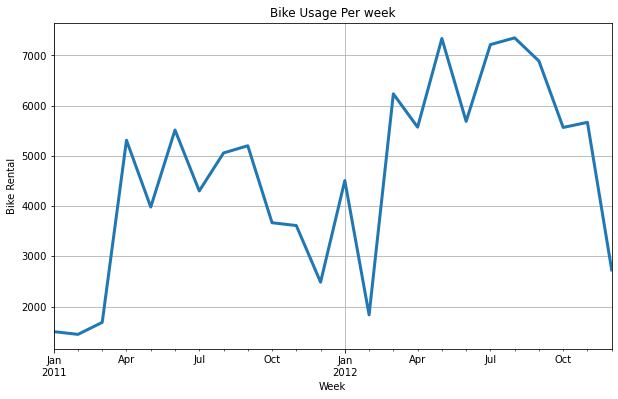

In [12]:
# Lets visualise the target variable by monthly
plt.figure(figsize=(10, 6))
bike['cnt'].asfreq('M').plot(linewidth=3)
plt.grid()
plt.title('Bike Usage Per week')
plt.xlabel('Week')
plt.ylabel('Bike Rental')

Text(0, 0.5, 'Bike Rental')

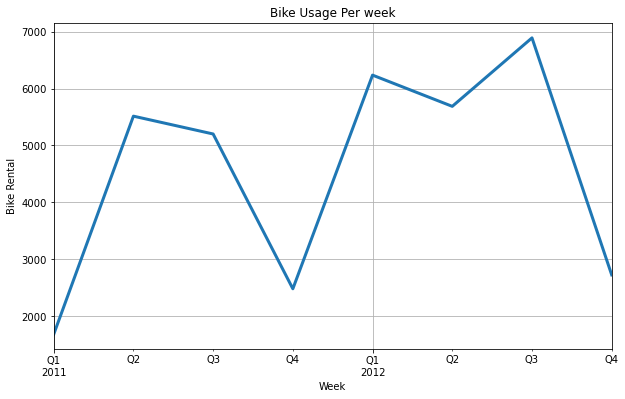

In [13]:
# Lets visualise the target variable by quarterly
plt.figure(figsize=(10, 6))
bike['cnt'].asfreq('Q').plot(linewidth=3)
plt.grid()
plt.title('Bike Usage Per week')
plt.xlabel('Week')
plt.ylabel('Bike Rental')

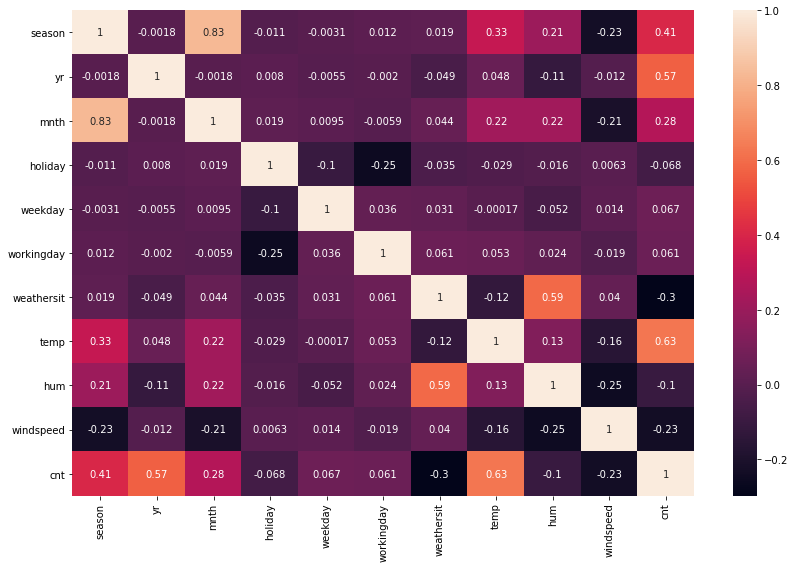

In [14]:
# Lets visualize a correlation heatmap across the entire dataset
plt.figure(figsize=(12, 8))
sns.heatmap(bike.corr(), annot=True)
plt.tight_layout()

### Data Preparation

In [15]:
# We will extract our numerical features

X_numerical = bike[['temp', 'hum', 'windspeed', 'cnt']]
X_numerical.head()

,temp,hum,windspeed,cnt
dteday,,,,
2011-01-01,0.344167,0.805833,0.160446,985
2011-01-02,0.363478,0.696087,0.248539,801
2011-01-03,0.196364,0.437273,0.248309,1349
2011-01-04,0.200000,0.590435,0.160296,1562
2011-01-05,0.226957,0.436957,0.186900,1600


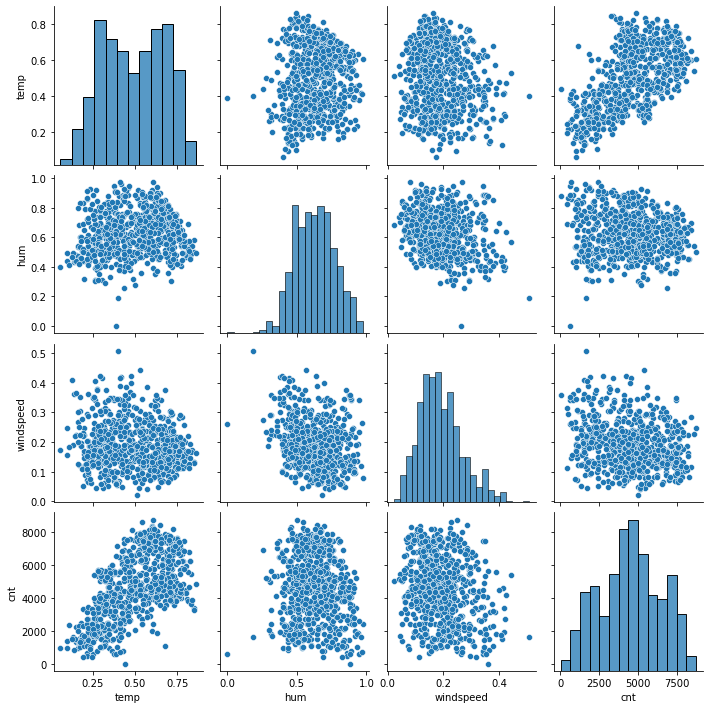

In [16]:
# we can run a pairplot and visualize the relationship with numerical attributes
sns.pairplot(X_numerical)

<AxesSubplot:>

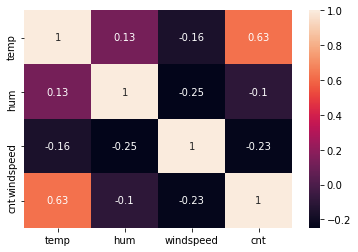

In [17]:
# lets check the correlation heatmap
sns.heatmap(X_numerical.corr(), annot=True)

In [18]:
# Now we will extract all categorical attributes
X_cat = bike[['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']]
X_cat.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit
dteday,,,,,,,
2011-01-01,1,0,1,0,6,0,2
2011-01-02,1,0,1,0,0,0,2
2011-01-03,1,0,1,0,1,1,1
2011-01-04,1,0,1,0,2,1,1
2011-01-05,1,0,1,0,3,1,1


In [19]:
# Now we will perform one hot encoding of the variables

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
X_cat = encoder.fit_transform(X_cat).toarray()

# Check the shape
X_cat.shape

(731, 32)

In [20]:
# Now we will create a dataframe out of it

X_cat = pd.DataFrame(X_cat)
X_cat.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [21]:
# Now we will concat two dataframes X_cat and X_numerical and before we do that, we need to reset the index of X_numerical 

X_numerical = X_numerical.reset_index()

X_all = pd.concat([X_cat, X_numerical], axis=1)

X_all.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,dteday,temp,hum,windspeed,cnt
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,2011-01-01,0.344167,0.805833,0.160446,985
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,2011-01-02,0.363478,0.696087,0.248539,801
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,2011-01-03,0.196364,0.437273,0.248309,1349
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,2011-01-04,0.200000,0.590435,0.160296,1562
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,2011-01-05,0.226957,0.436957,0.186900,1600


In [22]:
# Now we will drop the dteday column
X_all = X_all.drop(labels=['dteday'], axis=1)

X_all.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,temp,hum,windspeed,cnt
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.344167,0.805833,0.160446,985
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.363478,0.696087,0.248539,801
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.196364,0.437273,0.248309,1349
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.200000,0.590435,0.160296,1562
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.226957,0.436957,0.186900,1600


In [23]:
# Now extract into training and testing features

X = X_all.iloc[:, :-1].values
y = X_all.iloc[:, -1:].values

In [24]:
# Check the shape of the features
X.shape

(731, 35)

In [25]:
# Check the shape of the target
y.shape

(731, 1)

In [26]:
# Since the target variable is not normalized, we will normalize the output 

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y = scaler.fit_transform(y)

### Perform train, test split

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### Build and Train the model

In [28]:
# NN model constants

INPUT_SHAPE = (X_train.shape[1],)
HIDDEN_LAYER_UNITS = 100
HIDDEN_LAYER_ACTIVATION_FUNC = tf.keras.activations.relu
OUTPUT_LAYER_ACTIVATION_FUNC = tf.keras.activations.linear
OUTPUT_LAYER_UNITS = y_train.shape[1]

OPTIMIZER_FUNCTION = tf.keras.optimizers.Adam()
LOSS_FUNCTION = tf.keras.losses.MeanSquaredError()

NUMBER_EPOCHS = 100
BATCH_SIZE = 50
VALIDATION_SPLIT = 0.2

In [29]:
# Build the model

model = tf.keras.models.Sequential()

# add the input and first hidden layer
model.add(tf.keras.layers.Dense(units=HIDDEN_LAYER_UNITS, activation=HIDDEN_LAYER_ACTIVATION_FUNC, input_shape=INPUT_SHAPE))

# add the second layer
model.add(tf.keras.layers.Dense(units=HIDDEN_LAYER_UNITS, activation=HIDDEN_LAYER_ACTIVATION_FUNC))

# add the third layer
model.add(tf.keras.layers.Dense(units=HIDDEN_LAYER_UNITS, activation=HIDDEN_LAYER_ACTIVATION_FUNC))

# add the fourth layer
model.add(tf.keras.layers.Dense(units=HIDDEN_LAYER_UNITS, activation=HIDDEN_LAYER_ACTIVATION_FUNC))

# add the output layer
model.add(tf.keras.layers.Dense(units=OUTPUT_LAYER_UNITS, activation=OUTPUT_LAYER_ACTIVATION_FUNC))

# Check the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               3600      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 34,001
Trainable params: 34,001
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Compile the model

model.compile(optimizer=OPTIMIZER_FUNCTION, loss=LOSS_FUNCTION)

In [31]:
# Train the model

epochs_hist = model.fit(X_train, y_train, epochs=NUMBER_EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Epoch 1/100
10/10 [==============================] - 0s 16ms/step - loss: 0.1790 - val_loss: 0.1101
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0529 - val_loss: 0.0479
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0271 - val_loss: 0.0368
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0165 - val_loss: 0.0226
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0124 - val_loss: 0.0213
Epoch 6/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0096 - val_loss: 0.0169
Epoch 7/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0082 - val_loss: 0.0159
Epoch 8/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.0158
Epoch 9/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0069 - val_loss: 0.0151
Epoch 10/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0063 - val_loss: 0.0143
Epoch 11

### Evaluate the model

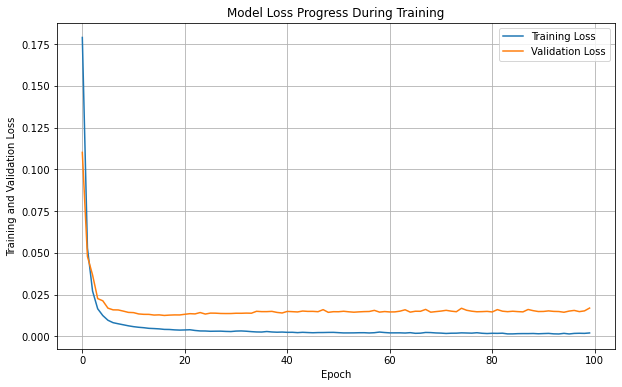

In [32]:
# lets visualize the loss
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])
plt.title('Model Loss Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend(['Training Loss', 'Validation Loss'])

Text(0, 0.5, 'True Values')

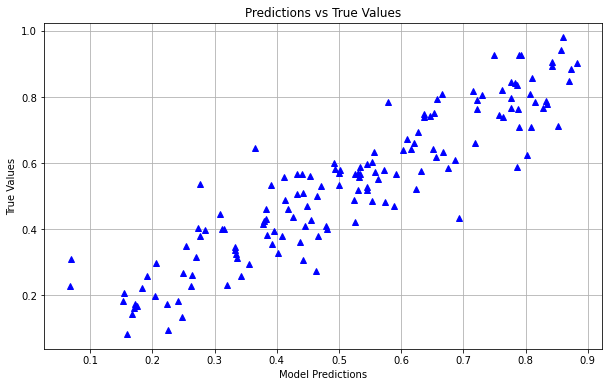

In [33]:
# Now lets visualize between predictions and actual
plt.figure(figsize=(10, 6))
y_predict = model.predict(X_test)
plt.grid()
plt.plot(y_test, y_predict, "^", color='b')
plt.title("Predictions vs True Values")
plt.xlabel("Model Predictions")
plt.ylabel("True Values")

In [34]:
# Now we will get the original values of the test and predictions from scaled data
y_predict_orig = scaler.inverse_transform(y_predict)
y_test_orig = scaler.inverse_transform(y_test)

Text(0, 0.5, 'True Values')

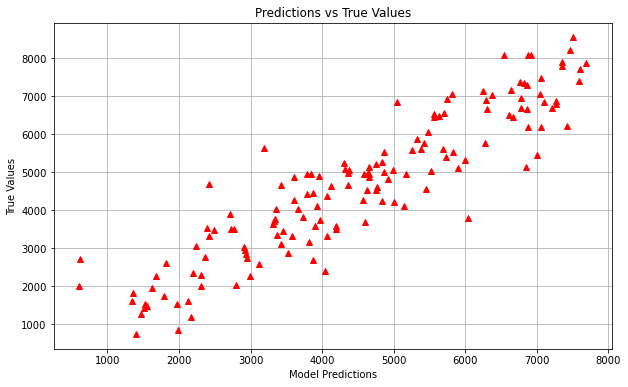

In [36]:
# We will plot the same to verify
plt.figure(figsize=(10, 6))
plt.plot(y_test_orig, y_predict_orig, "^", color='r')
plt.grid()
plt.title("Predictions vs True Values")
plt.xlabel("Model Predictions")
plt.ylabel("True Values")

In [37]:
# Validate with the regression validation parameters

k = X_test.shape[1]
n = len(X_test)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_predict_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_predict_orig)
MAE = mean_absolute_error(y_test_orig, y_predict_orig)
r2 = r2_score(y_test_orig, y_predict_orig)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2)

RMSE = 782.194 
MSE = 611827.578855366 
MAE = 617.3167878235279 
R2 = 0.813737308697831 
Adjusted R2 = 0.7550058294584083
